In [6]:
import pandas as pd
import numpy as np
import networkx as nx
import os.path
import tweepy
import re
import pickle
import nltk
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import *
import nltk
from PIL import Image
from nltk.collocations import *
from matplotlib import cm
import community as community_louvain 
import scipy.stats as stats

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Network creation

Under each network, the saved network is store, so for testing purpose, one can just run these.

#### Creating the social Network

In [7]:
#Reading in the data
dataT = pd.read_csv('House_twitter.csv', delimiter=';')

4 represetatives with no Twitter Handle have been removed from the data

In [104]:
dataT.head()

,FirstName,LastName,Full Name,Twitter Handle,St/Dis,State,Party
0,Alma,Adams,Alma Adams,RepAdams,NC12,NC,D
1,Robert,Aderholt,Robert Aderholt,Robert_Aderholt,AL04,AL,R
2,Pete,Aguilar,Pete Aguilar,RepPeteAguilar,CA31,CA,D
3,Rick,Allen,Rick Allen,RepRickAllen,GA12,GA,R
4,Colin,Allred,Colin Allred,RepColinAllred,TX32,TX,D


In [8]:
#Creating list containing the different parties
S_Republicans = list(dataT[dataT['Party']=="R"]["Twitter Handle"])
S_Democrats = list(dataT[dataT['Party']=="D"]["Twitter Handle"])
S_Independent = list(dataT[dataT['Party']=="I"]["Twitter Handle"])

In [9]:
#Creating a list containing all members and their Twitter usernames
UsernameList = dataT['Twitter Handle'].tolist()

The social network is based upon twitter links - Whether or not the members follow each other on twitter. In order to construct the network, we extract who the different members follows. As we later wanna do text analysis we also extract the 1000 latest tweets and retweets for all the members. 

We have created two developer accounts on twitter in order to do so, which have the different 'usercode' seen below. 

##### Twitter followers

In [ ]:
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAAPzAjgEAAAAAEm%2BzHXJaor%2BNm5ZmcCSIvZF5MxM%3DgRE2pthsK7wR8GLxAQGENTlN1cUDcaSRwzwleDUXzDLavZZx4N', wait_on_rate_limit=True)
#Different developer tokens 
#Mads
#AAAAAAAAAAAAAAAAAAAAABxZjAEAAAAAV1tndScZnptk9%2FMITZmuv3CVPDg%3DHgse5hzmFGgZnNCwVE6W4U5TKzXrGqIbW9xRvfExhRnfrYVEcT
#Kath
#AAAAAAAAAAAAAAAAAAAAAJlzjAEAAAAAheaq6YsmEsx8uzTCe2G9QdbWE3o%3D1OKDCz6UqUYjRQiP2p7CcQW9quHhFvWSDxaRofVCwjZQdquFw5

#Loop over all members
for element in UsernameList:
    tid = client.get_user(username=str(element)) #get the username from the member
    x = re.findall(r'[0-9]+', str(tid)) 

    #Find all people that the above member follows, 
    paginator = tweepy.Paginator(
        client.get_users_following, #Code to get the followers
        id=x[0],  
        max_results = 1000) 
    follows = []
    for e in paginator.flatten(limit=100000):
        follows.append(e)

    #Save the followers to a local path
    save_path = '/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/Followers'

    completeName = os.path.join(save_path, str(element)+".txt")     
    #open text file
    text_file = open(completeName, "w")
 
    #write string to file
    n = text_file.write(str(follows))
 
    #close file
    text_file.close()

##### Twitter text

In [986]:
client = tweepy.Client(bearer_token='AAAAAAAAAAAAAAAAAAAAABxZjAEAAAAAV1tndScZnptk9%2FMITZmuv3CVPDg%3DHgse5hzmFGgZnNCwVE6W4U5TKzXrGqIbW9xRvfExhRnfrYVEcT')
#Different developer tokens 
#Mads
#AAAAAAAAAAAAAAAAAAAAABxZjAEAAAAAV1tndScZnptk9%2FMITZmuv3CVPDg%3DHgse5hzmFGgZnNCwVE6W4U5TKzXrGqIbW9xRvfExhRnfrYVEcT
#Kath
#AAAAAAAAAAAAAAAAAAAAAJlzjAEAAAAAheaq6YsmEsx8uzTCe2G9QdbWE3o%3D1OKDCz6UqUYjRQiP2p7CcQW9quHhFvWSDxaRofVCwjZQdquFw5

#Loop over all members
for element in UsernameList:
    tid = client.get_user(username=str(element))
    x = re.findall(r'[0-9]+', str(tid))
    
    #Find all people that the above member follows, 
    paginator = tweepy.Paginator(
        client.get_users_tweets, #get the tweets and retweets for the member             
        id=x[0],                                   
        start_time = dt.datetime.fromisoformat('2021-11-09'),  #Time limit, from 2021-11-09 to 2022-11-09
    )
    i=0
    Info = "" #Create an empty string to concatinate all tweets
    for tweet in paginator.flatten(limit=1000): #Max number of tweets, if not datelimit is exceeded. 
        Info += str(tweet) #Concatinate all tweets. 

    #Save the tweets for the specific member, where the filename = member's twitter handle. 
    save_path = '/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House'

    completeName = os.path.join(save_path, str(element)+".txt")     
    #open text file
    text_file = open(completeName, "w")
 
    #write string to file
    n = text_file.write(Info)
 
    #close file
    text_file.close()

##### Constructing the social network

We construct the social network based on the above extracts. We remove self-loop edges, as it disturbs the analysis.

**Below is only for visual purpose, the graph is saved and can be accesed from storage, below**

In [10]:
S = nx.read_gpickle('SocialNetwork.gpickle')

In [107]:
S = nx.DiGraph() #Creating directed graph
for representative in UsernameList:
#Open file in the usernamelist and read the text
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/Followers", str(representative)+".txt"), 'r', encoding="utf-8") as c:
            nettext = c.read()

    #Find all usernames
    lst = re.findall(r'(?<=username=).*?(?=>)', nettext)
    #Create a list for all username for the member that are present in the usernamelist, so we only have representatives as nodes. 
    lst = list(set([x for x in lst if x in UsernameList]))

    #Create an edgelist for the representative and the other members in the list created above. 
    edgelist = [(o,v) for o in [representative] for v in lst]

    S.add_node(representative, Party=["R" if representative in S_Republicans else "D" if representative in S_Democrats else "I"]) #, lenght=len(nettext.split())
    S.add_edges_from(edgelist)
    S.remove_edges_from(list(nx.selfloop_edges(S)))

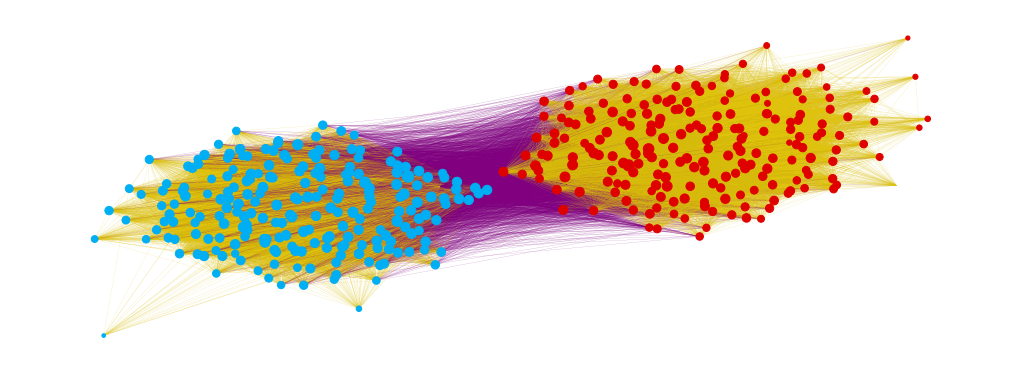

In [11]:
#Creating the undirected graph, reciprocal = false, meaning that there is an edge if just one of them follow the other. 
SU = S.to_undirected(reciprocal = False)
Largest_cc = sorted(nx.connected_components(SU), key=len, reverse=True)
CC_graph = SU.subgraph(Largest_cc[0])

#Defining node and edge colors.
nodecolors = ["#de0100" if node in S_Republicans else "#00AEF3" if node in S_Democrats else "grey" for node in CC_graph.nodes]
edgecolors = ["#DEC20B" if S.nodes[x]["Party"][0]==S.nodes[y]["Party"][0] else "purple" for (x,y) in CC_graph.edges]

#Plotting the figure
plt.figure(figsize=(14,5))
pos = nx.spring_layout(CC_graph, k=2.5*1/np.sqrt(len(S.nodes())), iterations = 20)
nx.draw(CC_graph, pos, node_color = nodecolors, edge_color=edgecolors, width=0.1, node_size=[x/2 for x in list(dict(S.in_degree()).values())]) #node_size=[G.in_degree(x) for x in G.nodes]
nx.draw
plt.show()

##### Social network statistics

In [12]:
print("Total number of member (nodes) = ", len(S.nodes()))
print("Number of Republicans = ", len(S_Republicans))
print("Number of Democrats = ", len(S_Democrats))
print("Number of Independent = ", len(S_Independent))
print("Number of links = ", len(S.edges()))

Total number of member (nodes) =  426
Number of Republicans =  207
Number of Democrats =  219
Number of Independent =  0
Number of links =  64952


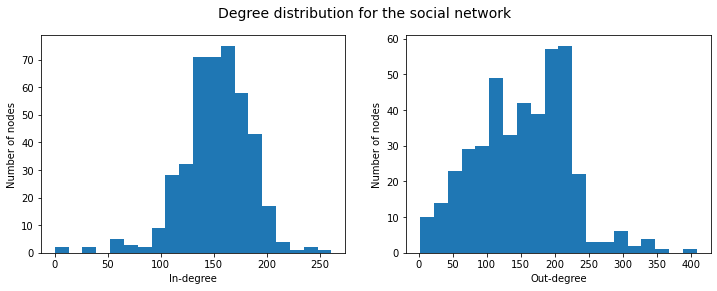

In [13]:
#Plotting the in and out degree distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Degree distribution for the social network',size=14)
Indegrees = [S.in_degree(n) for n in S.nodes()]
Outdegrees = [S.out_degree(n) for n in S.nodes()]
ax1.hist(Indegrees, bins = 20)
ax2.hist(Outdegrees, bins = 20)
_=ax1.set_xlabel("In-degree")
_=ax2.set_xlabel("Out-degree")
_=ax1.set_ylabel("Number of nodes")
_=ax2.set_ylabel("Number of nodes")

In [14]:
Indeg = dict(S.in_degree())
Outdeg = dict(S.out_degree())

In [15]:
print("Top 5 members who has the most followers", sorted(Indeg, key=Indeg.get, reverse=True)[:5])
print("Top 5 members who follows the most", sorted(Outdeg, key=Outdeg.get, reverse=True)[:5])

Top 5 members who has the most followers ['SpeakerPelosi', 'GOPLeader', 'LeaderHoyer', 'SteveScalise', 'WhipClyburn']
Top 5 members who follows the most ['RepHerrell', 'CongressmanRaja', 'RepGolden', 'RepChrisPappas', 'RepRussFulcher']


In [16]:
#Calculating L_max in order to identify if the network is sparse or dense
N = len(S.nodes())
(N*(N-1))/2 #If >> number of nodes then network is sparse. 

90525.0

##### See who follows and are followed the most from the other party.

We examine who follows the most from the other parties, i.e. who has the most links to nodes with a different node attribute than itself. This is done to try to identify members who are more centered. We start by counting the links between nodes with different node attributes and organize them in a dataframe. 

**First we look at the ones who are followed the most by other the other party**

In [45]:
#Defining different empty lists, in order to construct the dataframe, to see is followed most from the other party. 
Repp = []
FDP = []
Party = []

#Looping over the different members
for e in S.nodes():
    Repp.append(e) #Add the member to the representative list
    count = 0 #Create a counter
    for s in [x for (x,y) in S.in_edges(e)]: #Find all nodes who have an ingoing edge node s
        if S.nodes[s]["Party"][0]!=S.nodes[e]["Party"][0]: #See if the the two members have the same party
            count+=1 #If they don't have the same party count
    FDP.append(count) #Append count to member 
    Party.append(S.nodes[e]["Party"][0]) #Also add the members party

In [46]:
#Create a dataframe from the in degree information 
samlet = pd.DataFrame({"Congressman" : Repp, "Count" : FDP, "Party" : Party})

#Sort the dataframe, based on top count values
samlet.sort_values(by="Count", ascending=False).head(15)

,Congressman,Count,Party
11,SpeakerPelosi,52,D
231,HerreraBeutler,51,R
142,RepKinzinger,51,R
403,RepBrianFitz,46,R
297,RodneyDavis,42,R
279,GOPLeader,42,R
135,RepCuellar,41,D
314,CongressmanGT,41,R
315,RepFredUpton,40,R
260,RepJohnKatko,38,R


**Who followd the most from the other party**

In [19]:
#Defining different empty lists, in order to construct the dataframe, to see is followed most from the other party. 
ReppOut = []
FDPOut = []
Party = []

#Looping over the different members
for e in S.nodes():
    ReppOut.append(e) #Add the member to the representative list
    count = 0 #Create a counter
    for s in [y for (x,y) in S.out_edges(e)]: #Find all nodes who have an ingoing edge node s
        if S.nodes[s]["Party"][0]!=S.nodes[e]["Party"][0]: #See if the the two members have the same party
            count+=1 #If they don't have the same party count
    Party.append(S.nodes[e]["Party"][0]) #Add count to member
    FDPOut.append(count)

In [20]:
#Create a dataframe with information from the out degrees
samletOut = pd.DataFrame({"Congressman" : ReppOut, "Party" : Party, "Count" : FDPOut})

#Sort the dataframe, based on top count values
samletOut.sort_values(by="Count", ascending=False).head(20)

,Congressman,Party,Count
335,RepHerrell,R,210
216,CongressmanRaja,D,150
195,RepGolden,D,149
193,RepChrisPappas,D,141
383,RepRussFulcher,R,141
422,RepTrentKelly,R,133
374,RepAGonzalez,R,123
223,RepCartwright,D,121
138,RepSchneider,D,117
314,CongressmanGT,R,114


We are now plotting the different counts to see if trends can be seen among the two parties, or whether trends are happening among individual members, so more in-depth analysis needs to be done in the agreement network. 

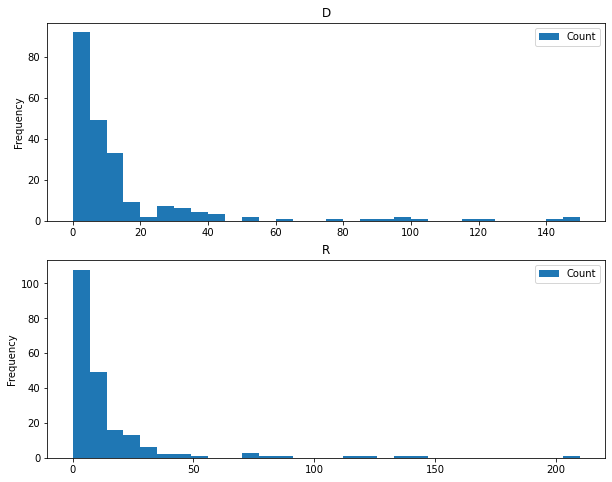

In [21]:
#Create a plot over the occurences of the counts
ax = samletOut.plot.hist(column=["Count"], by="Party", bins = 30, figsize=(10, 8))

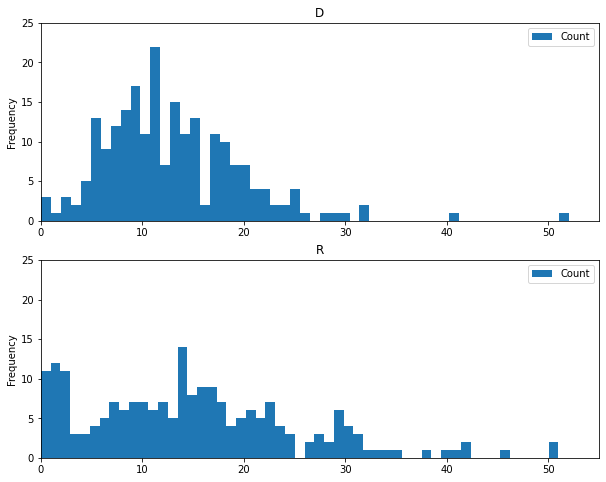

In [66]:
ax = samlet.plot.hist(column=["Count"], by="Party", bins = 53, stacked = True, ylim = (0,25),xlim = (0,55), figsize=(10, 8))


In [181]:
#Mean value for the counts of out degree to another party
samlet.groupby('Party', as_index=False)['Count'].mean()

,Party,Count
0,D,12.73516
1,R,14.94686


#### Social directed network to social undirected network

We create a subgraph consisting of the undirected social network. This is done in order to investigate the two parties and see if we on the basis of the two groupings, can indentify specific measures and tendencies. The undirected network were created above. 

##### Creating the two party subgraphs and their statistics

In [120]:
#Creating the two subgraphs
Dem = []
Rep = []

for e in CC_graph.nodes:
    if CC_graph.nodes[e]["Party"][0]=="R":
        Rep.append(e)
    elif CC_graph.nodes[e]["Party"][0]=="D":
        Dem.append(e)

In [121]:
R = CC_graph.subgraph(Rep)
D = CC_graph.subgraph(Dem)

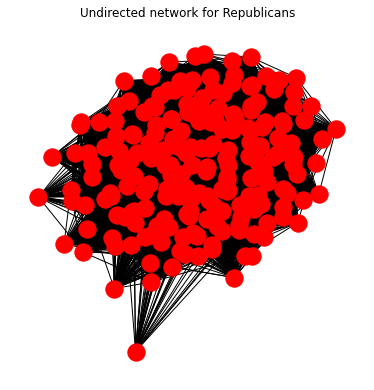

In [122]:
#Plotting the graph for the Republicans
plt.figure(figsize=(5,5)) 
nx.draw(R, node_color = "red")
plt.title("Undirected network for Republicans")
plt.show() 

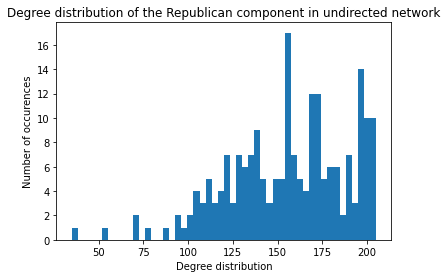

In [123]:
#Plotting the degree distribution for the Republicans
degrees = [R.degree(n) for n in R.nodes()]
plt.title("Degree distribution of the Republican component in undirected network")
plt.xlabel("Degree distribution")
plt.ylabel("Number of occurences")
plt.hist(degrees, bins =50)
plt.show()

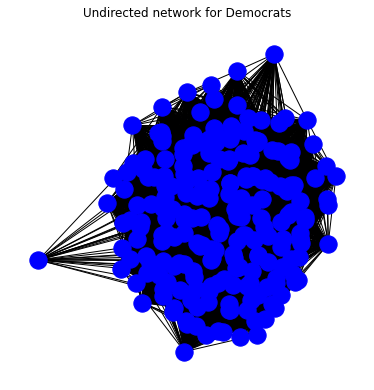

In [124]:
#Plotting the graph for the Democrats
plt.figure(figsize=(5,5)) 
nx.draw(D, node_color="blue")
plt.title("Undirected network for Democrats")
plt.show() 

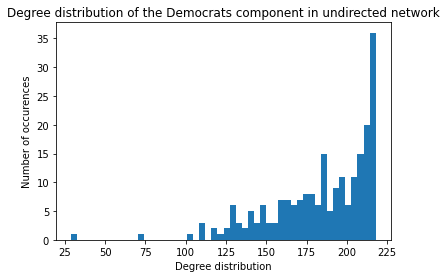

In [125]:
#Plotting the degree distribution for the Democrats
degrees = [D.degree(n) for n in D.nodes()]
plt.title("Degree distribution of the Democrats component in undirected network")
plt.xlabel("Degree distribution")
plt.ylabel("Number of occurences")
plt.hist(degrees, bins =50)
plt.show()

##### Creating Communities

We are looking at creating communities, in order to support our hypothesis that the network is divided into communities, namely their parties. The community detection is mainly used for supporting the hypothesis, as the analysis shows two clear communities, namely their parties.

In [164]:
#Defining the position for the community network
pos = nx.spring_layout(CC_graph)

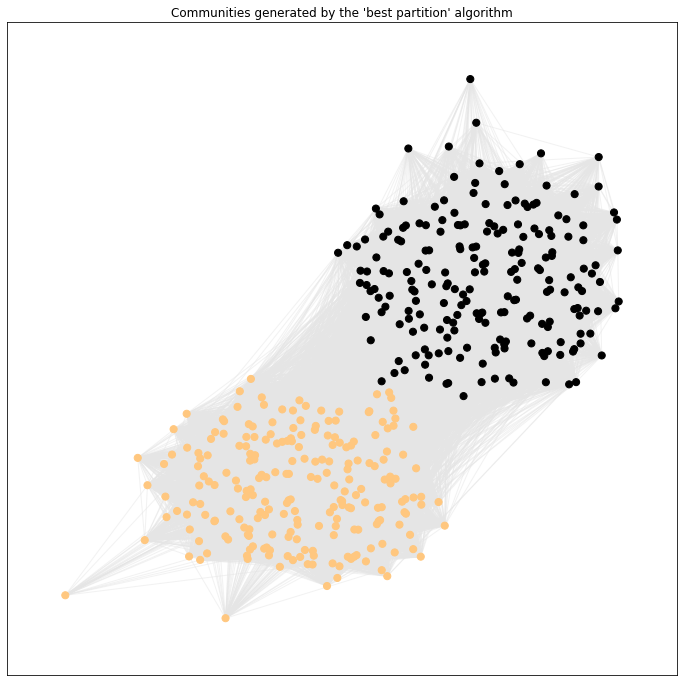

In [165]:
#Creating the communities and plotting it. 
comm = community_louvain.best_partition(CC_graph) #Only using the largest connected component to create the communities
plt.figure(3, figsize=(12,12))
colormap = cm.get_cmap('copper', max(comm.values()) +1) #Still using the values of the connected components as values for the colormap
nx.draw_networkx_nodes(CC_graph, pos, comm.keys(), node_size=50, cmap = colormap, node_color=list(comm.values()))
nx.draw_networkx_edges(CC_graph, pos, alpha=0.5, edge_color='#e5e5e5')
plt.title("Communities generated by the 'best partition' algorithm")
plt.show() 

In [171]:
#Creating two lists containing the members in the two communities
Comm0 = []
Comm1 = []

for key, value in comm.items() :
    if value == 0:
        Comm0.append(key)
    if value == 1:
        Comm1.append(key)

##### Misclassifications

We want to see if the communities algorithm has misclassified any members. We see members of the Republican party in Community 1 and Democrats in Community 0 and compare them with the original lists. 

In [175]:
misclassRep = list(set(S_Republicans) - set(Comm0))

In [176]:
misclassDem = list(set(S_Democrats) - set(Comm1))

In [177]:
print("Misclassifies Republicans = ", misclassRep)
print("Misclassifies Democrats = ", misclassDem)

Misclassifies Republicans =  []
Misclassifies Democrats =  []


### Constructing the agreement network

**Below is only for visual purpose, the graph is saved and can be accesed from storage, below**

In [132]:
#Reading and defining data
dataCongress = pd.read_csv("Data_Votes_Congress.csv", delimiter=";")
infoCongress = pd.read_csv("Information_Congress.csv", delimiter=";")

Democrats_Con = list(infoCongress[infoCongress["Party"]=="D"]["name"])
Republicans_Con = list(infoCongress[infoCongress["Party"]=="R"]["name"])

dataCongress = dataCongress.set_index("Congressman")
CongressList = infoCongress.set_index("name")

In [69]:
G = nx.read_gpickle('PoliticalNetwork.gpickle')

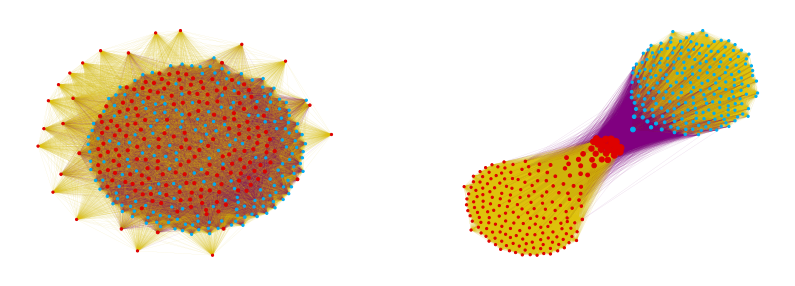

In [133]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(14,5))
ax = axes.flatten()

threshold = [30,50] #setting the thresholds

for l,t in enumerate(threshold):
    G = nx.Graph() #generating the graph
    for i, Rep1 in enumerate(dataCongress.columns):
        for Rep2 in dataCongress.index[i+1:]: #looping over the all other representative except the one choosen in the outer-loop. 
            if dataCongress.loc[Rep1,Rep2] > t/100: #checking if the agreementscore is greater then the threshold
                G.add_edge(Rep1, Rep2, aggreementP=dataCongress.loc[Rep1,Rep2]) #Add an edge if agreement score > threshold
    #Defining edge and nodecolor. Nodecolor based on party color, edge color based if the connection is between same or different party. 
    edgecolors = ["#DEC20B" if CongressList.loc[Rep1,"Party"]==CongressList.loc[Rep2,"Party"] else "purple" for (Rep1,Rep2) in G.edges]
    nodecolors = ["#de0100" if node in Republicans_Con else "#00AEF3" for node in G.nodes]
    total = sum(list((nx.betweenness_centrality(G).values())))
    pos=nx.spring_layout(G,scale=20, k=18/np.sqrt(G.order()))
    nx.draw(G, node_size=[(x / total*1000)+5 for x in list(nx.betweenness_centrality(G).values())], pos=pos, edge_color=edgecolors, node_color=nodecolors,width=0.05, ax=ax[l])
    ax[l].title.set_color('black')
    fig.set_facecolor('white')

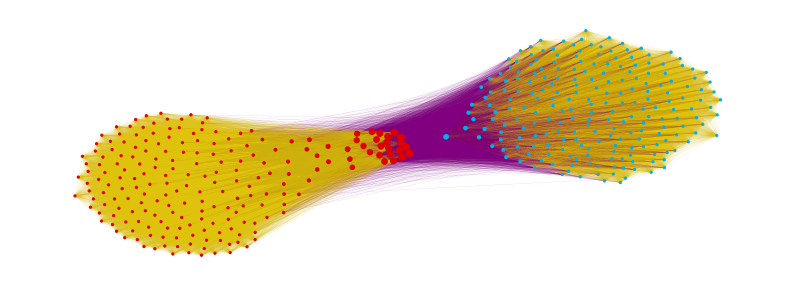

In [134]:
#Plotting the same graph as above, just only with agreement threshold on 50%
fig, axes = plt.subplots(figsize=(14,5))

G = nx.Graph()
for i, Rep1 in enumerate(dataCongress.columns):
    for Rep2 in dataCongress.index[i+1:]:
        if dataCongress.loc[Rep1,Rep2] > 0.5:
            G.add_node(Rep1, Party=["D" if Rep1 in Democrats_Con else "R"])
            G.add_edge(Rep1, Rep2, aggreementP=dataCongress.loc[Rep1,Rep2])

edgecolors = ["#DEC20B" if CongressList.loc[Rep1,"Party"]==CongressList.loc[Rep2,"Party"] else "purple" for (Rep1,Rep2) in G.edges]
nodecolors = ["#de0100" if node in Republicans_Con else "#00AEF3" for node in G.nodes]
total = sum(list((nx.betweenness_centrality(G).values())))
pos=nx.spring_layout(G,scale=20, k=18/np.sqrt(G.order()))
nx.draw(G, node_size=[(x / total*1000)+5 for x in list(nx.betweenness_centrality(G).values())], pos=pos, edge_color=edgecolors, node_color=nodecolors,width=0.05)
#nx.draw_networkx_labels(G, pos=pos, font_color="w", ax=ax[l])
#ax[l].set_title(str(t) + "% agreement threshhold")
fig.set_facecolor('white')

##### Agreement network statistics

In [135]:
print("Number of total nodes = ",len(G.nodes()))
print("Number of links = ", len(G.edges()))
print("Min degree = ", min((dict(G.degree())).values()))
print("Max degree = ", max((dict(G.degree())).values()))

Number of total nodes =  425
Number of links =  50928
Min degree =  199
Max degree =  420


##### Creating subgraphs

In order to test the hypothesis that the two parties form two fully connected networks, we create two subgraphs containing only the nodes and edges within the two parties. Hence Democrats have their own network and Republicans have their own network. 

In [136]:
#Analyzing the subgraphs in order to see if the indivdual networks in parties are fully connected
DemGraph = G.subgraph(Democrats_Con)
RepGraph = G.subgraph(Republicans_Con) 

print("Democrats total number of nodes = ",len(DemGraph.nodes()))
print("Average degree for Democrats = ", np.mean(list(dict(DemGraph.degree()).values())))
print("Republican total number of nodes = ", len(RepGraph.nodes()))
print("Average degree for Republicans = ",np.mean(list(dict(RepGraph.degree()).values())))

Democrats total number of nodes =  218
Average degree for Democrats =  217.0
Republican total number of nodes =  207
Average degree for Republicans =  205.81642512077295


In [70]:
BC = nx.betweenness_centrality(G)

In [138]:
Top20Bet = sorted(BC.items(), key=lambda x: x[1], reverse=True)[0:20]
Top20Bet

[('B. FITZPATRICK', 0.019071623129662322),
 ('F. UPTON', 0.01821936847767639),
 ('J. KATKO', 0.018068913287031994),
 ('A. GONZALEZ', 0.017718832087395865),
 ('P. MEIJER', 0.017365926653156376),
 ('D. JOYCE', 0.01675598902855802),
 ('D. BACON', 0.016242324139504605),
 ('M. SALAZAR', 0.014865133192614479),
 ('C. SMITH', 0.013974570914405201),
 ('Y. KIM', 0.013667276124708765),
 ('D. VALADAO', 0.013533409612585883),
 ('T. COLE', 0.013337749691301144),
 ('C. JACOBS', 0.013194477050806667),
 ('J. HERRERA BEUTLER', 0.013051649142921432),
 ('D. NEWHOUSE', 0.012670332887655839),
 ('N. MALLIOTAKIS', 0.012224977434657128),
 ('M. TURNER', 0.012122127187113241),
 ('M. MILLER-MEEKS', 0.012011723864467316),
 ('M. GARCIA', 0.01063761691109354),
 ('A. GARBARINO', 0.010003466945193534)]

## Text analysis

The following text analysis code is the same, and the 'detailed' comments will only be present in the first example of the code. 

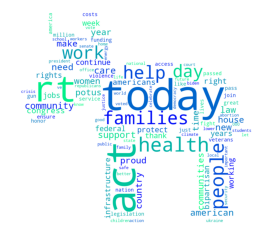

[(('health', 'care'), 0.000792351062442967),
 (('gun', 'violence'), 0.0005178406686521665),
 (('mental', 'health'), 0.00045375690663136887),
 (('bipartisan', 'infrastructure'), 0.00041004206652427226),
 (('infrastructure', 'law'), 0.0003628801780933185),
 (('supreme', 'court'), 0.00035990318181362374),
 (('inflation', 'reduction'), 0.00030960761308825447),
 (('reduction', 'act'), 0.0003067873008232805),
 (('united', 'states'), 0.0002911188993512028),
 (('social', 'security'), 0.000283284698615164),
 (('years', 'ago'), 0.0002748237618202421),
 (('climate', 'change'), 0.0002640125648045085),
 (('make', 'sure'), 0.0002585286242892813),
 (('look', 'forward'), 0.0002514778436268464),
 (('every', 'day'), 0.00025038105552380093),
 (('american', 'people'), 0.0002425468547877621),
 (('president', 'biden'), 0.00023972654252278812),
 (('lower', 'costs'), 0.00023815970237558035),
 (('loved', 'ones'), 0.00023768965033141802),
 (('town', 'hall'), 0.00023753296631669725),
 (('small', 'businesses'), 0

In [139]:
Demdoc = []
#Looping over the different members in the democrats list, and opening their tweets-file. 
for member in S_Democrats:
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House", member+".txt"), 'r', encoding="utf-8") as c:
            pageDem = c.read() 
            Demdoc.append(pageDem)
            newlistDem = [re.sub(r'[^a-zA-Z],-+', ' ', x) for x in Demdoc] 
            newlistDem = [re.sub(r'http\S+', '', x) for x in newlistDem] #Removing all http links (present when retweeting)
            newlistDem = [re.sub(r'&amp;', '', x) for x in newlistDem] #Removing all &-signs
            newlistDem = [re.sub(r'\n', '', x) for x in newlistDem] #Removing line change. 
            

#Creating the TF-IDF scores by converting the raw document into a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english') 
vecs = vectorizer.fit_transform(newlistDem) 
feature_names = vectorizer.get_feature_names_out() 
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)


#Creating the TF-IDF 'vector'
dfnew = df.T.sum(axis=1)

#Plotting the wordcloud
stopwords = set(STOPWORDS)
#Getting the picture for the wordcloud
mask = np.array(Image.open(r'/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/Democrats.jpg'))
#Defining features of the wordclouds and plotting the wordcloud
Cloud = WordCloud(background_color="white", colormap="winter", max_words=100, stopwords=stopwords, mask = mask, width=mask.shape[1], height=mask.shape[0], collocations=True).generate_from_frequencies(dfnew)
plt.imshow(Cloud)
plt.axis("off")
plt.show()

#Creating the bigram collocations code found on: https://www.nltk.org/howto/collocations.html 
bigram_measures = nltk.collocations.BigramAssocMeasures()

#Convert the text vector into a string and make everything lower case. 
textDem = " ".join(newlistDem)
textDem = textDem.lower()

tokens = nltk.wordpunct_tokenize(textDem) #Divides the string into lists, where each word is it own 'element'
finder = BigramCollocationFinder.from_words(tokens) #
ignored_words = nltk.corpus.stopwords.words('english') #Defining english stopwords. 
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words) #Removing english stopwords.
scored_Demo = finder.score_ngrams(bigram_measures.raw_freq)
scored_Demo

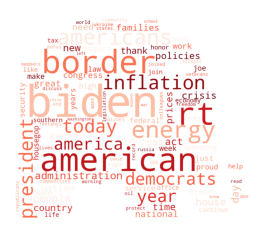

[(('President', 'Biden'), 0.0012816540577797483),
 (('Joe', 'Biden'), 0.0008270100835049806),
 (('Biden', 'Administration'), 0.0007127613909002562),
 (('southern', 'border'), 0.000673973254522109),
 (('American', 'energy'), 0.0006199049432071159),
 (('American', 'people'), 0.000604389688655857),
 (('gas', 'prices'), 0.0004642822384657012),
 (('national', 'security'), 0.00043536744589290055),
 (('Biden', 'administration'), 0.00038035881612025543),
 (('United', 'States'), 0.0003796535772770164),
 (('law', 'enforcement'), 0.00034674243125919457),
 (('energy', 'production'), 0.0002752782284776385),
 (('White', 'House'), 0.00026658028274435705),
 (('energy', 'independence'), 0.00025741217778224953),
 (('supply', 'chain'), 0.0002541210631804673),
 (('border', 'crisis'), 0.00024753883397690295),
 (('Biden', 'Admin'), 0.0002376654901715564),
 (('small', 'businesses'), 0.00023249373865447012),
 (('American', 'families'), 0.00023131834058240505),
 (('Supreme', 'Court'), 0.00022755706675179683),


In [49]:
Repdoc = []
#Looping over the different members in the democrats list, and opening their tweets-file. 
for member in S_Republicans:
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House", member+".txt"), 'r', encoding="utf-8") as c:
            Reppage = c.read()
            Repdoc.append(Reppage)
            newlistRep = [re.sub(r'[^a-zA-Z],-+', ' ', x) for x in Repdoc]
            newlistRep = [re.sub(r'http\S+', '', x) for x in newlistRep]#Removing all http links (present when retweeting)
            newlistRep = [re.sub(r'&amp;', '', x) for x in newlistRep]#Removing all &-signs
            newlistRep = [re.sub(r'\n', '', x) for x in newlistRep]#Removing all line changes
            

#Creating the TF-IDF scores scores by converting the raw document into a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(newlistRep)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)


#Creating the TF-IDF 'vector'
dfnew = df.T.sum(axis=1)


#Plotting the wordcloud
stopwords = set(STOPWORDS)
#Defining picture for wordcloud
mask = np.array(Image.open(r'/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/Repub.jpg'))
#Defining features of the wordclouds and plotting the wordcloud
Cloud = WordCloud(background_color="white", colormap='Reds', max_words=100, stopwords=stopwords, mask = mask, width=mask.shape[1], height=mask.shape[0], collocations=True).generate_from_frequencies(dfnew)
plt.imshow(Cloud)
plt.axis("off")
plt.show()

#Creating the bigram collocations code found on: https://www.nltk.org/howto/collocations.html 
textRep = " ".join(newlistRep)

tokens = nltk.wordpunct_tokenize(textRep) #Divides the string into lists, where each word is it own 'element'
finder = BigramCollocationFinder.from_words(tokens)
ignored_words = nltk.corpus.stopwords.words('english') #Defining english stopwords
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words) #removing english stopwords
scored_Rep = finder.score_ngrams(bigram_measures.raw_freq)
scored_Rep

##### Wordclouds and sentiment analysis based
First we start by doing a sentiment score analysis based on the two parties. 

In [50]:
#Reading the sentiment data
data = pd.read_csv("gladellersur.csv", delimiter=";", usecols=["word", "happiness_average"])
data = data.set_index("word")

gslist = []
clist = []

#looping over each members tweets and calculating the sentiment score.  
for member in S_Democrats:
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House", member+".txt"), 'r', encoding="utf-8") as f:
        pageDemo = f.read()
        pageDemo = [x.lower() for x in nltk.word_tokenize(pageDemo)] #Tokenize the tweets
        word_freq = nltk.FreqDist(pageDemo) #Using the frequency distribution to record every time a record occur.
        stopwords = nltk.corpus.stopwords.words('english') #Removing stopwords
        
        ## from https://stackoverflow.com/questions/31826950/dropping-specific-words-out-of-an-nltk-distribution-beyond-stopwords
        dict_filter = lambda word_freq, stopwords: dict( (word,word_freq[word]) for word in word_freq if word not in stopwords )
        filtered_word_freq = dict_filter(word_freq, stopwords)
        
        #Creating two list for sentiment and its weigth. For later to create an dataframe for the sentiment scores
        senti = []
        weight = []
        #calculating sentiment score
        for w,f in zip(dict(filtered_word_freq),dict(filtered_word_freq).values()): 
            try:
                
                senti.append(data.loc[w,"happiness_average"]*f) #Finding the word and its happiness score in the 'gladellersur.csv' file.
                weight.append(f) #Append the weigth of the word, the weight tells how much the word occurs.
            except:
                continue
        gslist.append(np.sum(senti)/np.sum(weight)) #Calculating the overall sentiment score based on the words sentiment and how much it appears in the tweets. 
        clist.append(member.replace(".txt","")) #append the sentiments score to a specific member. 

#Create a dataframe for the sentiment score at the members     
SentimentDem = pd.DataFrame({"Twitter Handle" : clist , "Sentiment_Score" : gslist})

#Removing nan values (empty webpages)
SentimentDem = SentimentDem.dropna()

In [51]:
#Reading the sentiment data
data = pd.read_csv("gladellersur.csv", delimiter=";", usecols=["word", "happiness_average"])
data = data.set_index("word")

gslist = []
clist = []

#looping over each members tweets and calculating the sentiment score.  
for member in S_Republicans:
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House", member+".txt"), 'r', encoding="utf-8") as f:
        pageRepub = f.read()
        pageRepub = [x.lower() for x in nltk.word_tokenize(pageRepub)] #Tokenize the tweets
        word_freq = nltk.FreqDist(pageRepub) #Using the frequency distribution to record every time a record occur.
        stopwords = nltk.corpus.stopwords.words('english') #Removing stopwords
        
        ## from https://stackoverflow.com/questions/31826950/dropping-specific-words-out-of-an-nltk-distribution-beyond-stopwords
        dict_filter = lambda word_freq, stopwords: dict( (word,word_freq[word]) for word in word_freq if word not in stopwords )
        filtered_word_freq = dict_filter(word_freq, stopwords)
        
        #Creating two list for sentiment and its weigth. For later to create an dataframe for the sentiment scores
        senti = []
        weight = []
        #calculating sentiment score
        for w,f in zip(dict(filtered_word_freq),dict(filtered_word_freq).values()): 
            try:
                
                senti.append(data.loc[w,"happiness_average"]*f) #Finding the word and its happiness score in the 'gladellersur.csv' file.
                weight.append(f) #Append the weigth of the word, the weight tells how much the word occurs.
            except:
                continue
        gslist.append(np.sum(senti)/np.sum(weight)) #Calculating the overall sentiment score based on the words sentiment and how much it appears in the tweets. 
        clist.append(member.replace(".txt","")) #append the sentiments score to a specific member. 

#Create a dataframe for the sentiment score at the members     
SentimentRep = pd.DataFrame({"Twitter Handle" : clist , "Sentiment_Score" : gslist})

#Removing nan values (empty webpages)
SentimentRep = SentimentRep.dropna()

/var/folders/ng/ppmp_v5s0k51l14sqbjms5x40000gn/T/ipykernel_97630/3375674335.py:31: RuntimeWarning: invalid value encountered in double_scalars
  gslist.append(np.sum(senti)/np.sum(weight)) #Calculating the overall sentiment score based on the words sentiment and how much it appears in the tweets.


Now we are plotting the sentiment distribution for republicans and democrats

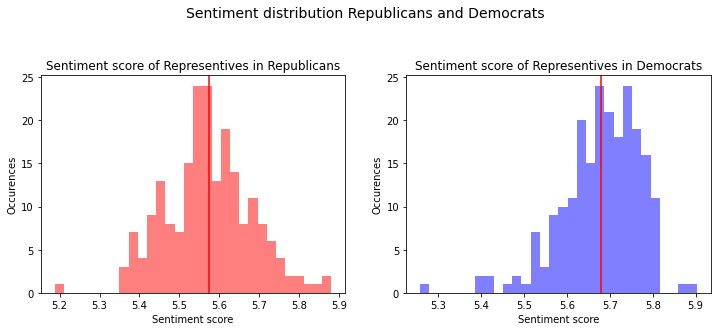

In [140]:
#Creating the figure 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('Sentiment distribution Republicans and Democrats',size=14, y=1.12)

#Defining the different histograms and its mean value, we use a bin = 30
ax1.hist(SentimentRep[SentimentRep["Twitter Handle"].isin(S_Republicans)]["Sentiment_Score"], 30, facecolor='red', alpha=0.5)
ax2.hist(SentimentDem[SentimentDem["Twitter Handle"].isin(S_Democrats)]["Sentiment_Score"], 30, facecolor='blue', alpha=0.5)
ax1.axvline(x = SentimentRep[SentimentRep["Twitter Handle"].isin(S_Republicans)]["Sentiment_Score"].mean(), color = 'r')
ax2.axvline(x = SentimentDem[SentimentDem["Twitter Handle"].isin(S_Democrats)]["Sentiment_Score"].mean(), color = 'r')
_=ax1.set_title("Sentiment score of Representives in Republicans")
_=ax2.set_title("Sentiment score of Representives in Democrats")
_=ax1.set_xlabel("Sentiment score")
_=ax2.set_xlabel("Sentiment score")
_=ax1.set_ylabel("Occurences")
_=ax2.set_ylabel("Occurences")

In [141]:
print("The average sentiment score for Republicans sentimentscore = ",SentimentRep[SentimentRep["Twitter Handle"].isin(S_Republicans)]["Sentiment_Score"].mean())
print("The 10% percentile for Republicans sentimentscore = ",SentimentRep[SentimentRep["Twitter Handle"].isin(S_Republicans)]["Sentiment_Score"].quantile(0.1))
print("The 90% percentilefor Republicans sentimentscore = ",SentimentRep[SentimentRep["Twitter Handle"].isin(S_Republicans)]["Sentiment_Score"].quantile(0.9))
print("The average sentiment score for Democrats sentimentscore = ", SentimentDem[SentimentDem["Twitter Handle"].isin(S_Democrats)]["Sentiment_Score"].mean())
print("The 10% percentile for Democrats sentimentscore = ",SentimentDem[SentimentDem["Twitter Handle"].isin(S_Democrats)]["Sentiment_Score"].quantile(0.1))
print("The 90% percentilefor Democrats sentimentscore = ",SentimentDem[SentimentDem["Twitter Handle"].isin(S_Democrats)]["Sentiment_Score"].quantile(0.9))

The average sentiment score for Republicans sentimentscore =  5.57312968955087
The 10% percentile for Republicans sentimentscore =  5.434992252456722
The 90% percentilefor Republicans sentimentscore =  5.711952925825728
The average sentiment score for Democrats sentimentscore =  5.679421447298479
The 10% percentile for Democrats sentimentscore =  5.575398561716157
The 90% percentilefor Democrats sentimentscore =  5.778736484155997


In [150]:
data_group1 = SentimentRep[SentimentRep["Twitter Handle"].isin(S_Republicans)]["Sentiment_Score"]
data_group2 = SentimentDem[SentimentDem["Twitter Handle"].isin(S_Democrats)]["Sentiment_Score"]

In [151]:
print(stats.ttest_ind(data_group1, data_group2, equal_var = False))

Ttest_indResult(statistic=-10.860691074902716, pvalue=2.9126125403912106e-24)


##### Analyzing the sentiment of members with top 20 betweeness centrality
Now we find the members with the top 20 betwenness centrality. This is done as we earlier concluded that the two party subgraphs individually are fully conected. Hence the members with the highest betwenness centrality, must connect people across parties. 

In [54]:
Top20 = dict(sorted(BC.items(), key=lambda item: item[1], reverse=True)[:20])
Top20List = list(Top20.keys())

In [55]:
Top20List

['B. FITZPATRICK',
 'F. UPTON',
 'J. KATKO',
 'A. GONZALEZ',
 'P. MEIJER',
 'D. JOYCE',
 'D. BACON',
 'M. SALAZAR',
 'C. SMITH',
 'Y. KIM',
 'D. VALADAO',
 'T. COLE',
 'C. JACOBS',
 'J. HERRERA BEUTLER',
 'D. NEWHOUSE',
 'N. MALLIOTAKIS',
 'M. TURNER',
 'M. MILLER-MEEKS',
 'M. GARCIA',
 'A. GARBARINO']

We construct the top 5, 10, 15 and 19 based on above. We see that the member 'C. SMITH' is included in top 20, but as he does not have twitter, we remove him from the further analysis However his presence in above is still important, which is the reason for not excluding him in the network. 

**There are only extensive code comments on the first code for the various wordclouds. The codes are the same, it is plot different lists are run through and therefore also different text variables are returned, for when later to make Bigram collocations.**

In [72]:
Top5 = ['RepBrianFitz', 'RepFredUpton', 'RepJohnKatko', 'RepAGonzalez', 'RepDonBacon']
Top6 = ['RepBrianFitz', 'RepFredUpton', 'RepJohnKatko', 'RepAGonzalez', 'HerreraBeutler', 'RepNewhouse']
Top10 = ['RepBrianFitz', 'RepFredUpton', 'RepJohnKatko', 'RepAGonzalez', 'RepMeijer', 'RepDaveJoyce', 'RepDonBacon', 'RepMariaSalazar', 'RepYoungKim', 'RepDavidValadao']
Top15 = ['RepBrianFitz', 'RepFredUpton', 'RepJohnKatko', 'RepAGonzalez', 'RepMeijer', 'RepDaveJoyce', 'RepDonBacon', 'RepMariaSalazar', 'RepYoungKim', 'RepDavidValadao', 'TomColeOK04', 'RepJacobs', 'HerreraBeutler', 'RepNewhouse', 'RepMalliotakis']
Top19 = ['RepBrianFitz', 'RepFredUpton', 'RepJohnKatko', 'RepAGonzalez', 'RepMeijer', 'RepDaveJoyce', 'RepDonBacon', 'RepMariaSalazar', 'RepYoungKim', 'RepDavidValadao', 'TomColeOK04', 'RepJacobs', 'HerreraBeutler', 'RepNewhouse', 'RepMalliotakis', 'RepMikeTurner', 'RepMMM', 'RepMikeGarcia', 'RepGarbarino']

In [63]:
print("Lenght top 5 = ", len(Top5))
print("Lenght top 10 = ", len(Top10))
print("Lenght top 15 = ", len(Top15))
print("Lenght top 20 = ", len(Top19))

Lenght top 5 =  5
Lenght top 10 =  10
Lenght top 15 =  15
Lenght top 20 =  19


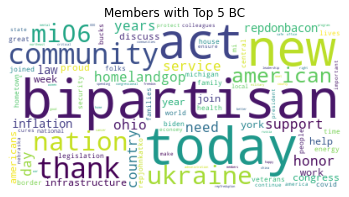

In [58]:
doc5 = []
#Looping over the different members in the democrats list, and opening their tweets-file. 
for member in Top5:
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House", member+".txt"), 'r', encoding="utf-8") as c:
            page2 = c.read()
            doc5.append(page2)
            newlist5 = [re.sub(r'[^a-zA-Z],-+', ' ', x) for x in doc5]
            newlist5 = [re.sub(r'http\S+', '', x) for x in newlist5] #Removing all http links (present when retweeting)
            newlist5 = [re.sub(r'&amp;', '', x) for x in newlist5] #Removing all &-signs
            newlist5 = [re.sub(r'\n', '', x) for x in newlist5] #Removing all line changes
            

#Creating the TF-IDF scores scores by converting the raw document into a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(newlist5)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)


#Creating the TF-IDF 'vector'
dfnew = df.T.sum(axis=1)
dfnew = dfnew.drop(labels=['rt'])
    
#Defining features of the wordclouds and plotting the wordcloud 
Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(dfnew)
plt.title("Members with Top 5 BC")
plt.imshow(Cloud)
plt.axis("off")
plt.show()

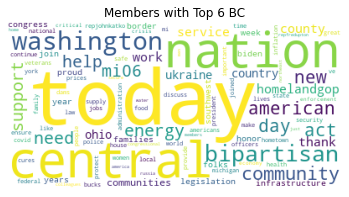

In [73]:
doc6 = []
#Looping over the different members in the democrats list, and opening their tweets-file. 
for member in Top6:
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House", member+".txt"), 'r', encoding="utf-8") as c:
            page2 = c.read()
            doc6.append(page2)
            newlist6 = [re.sub(r'[^a-zA-Z],-+', ' ', x) for x in doc6]
            newlist6 = [re.sub(r'http\S+', '', x) for x in newlist6] #Removing all http links (present when retweeting)
            newlist6 = [re.sub(r'&amp;', '', x) for x in newlist6] #Removing all &-signs
            newlist6 = [re.sub(r'\n', '', x) for x in newlist6] #Removing all line changes
            

#Creating the TF-IDF scores scores by converting the raw document into a matrix of TF-IDF features
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(newlist6)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)


#Creating the TF-IDF 'vector'
dfnew = df.T.sum(axis=1)
dfnew = dfnew.drop(labels=['rt'])
    
#Defining features of the wordclouds and plotting the wordcloud 
Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(dfnew)
plt.title("Members with Top 6 BC")
plt.imshow(Cloud)
plt.axis("off")
plt.show()

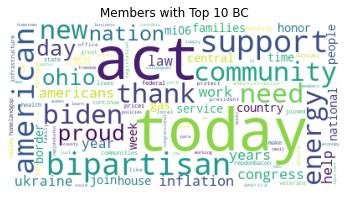

In [59]:
doc10 = []
for member in Top10:
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House", member+".txt"), 'r', encoding="utf-8") as c:
            page2 = c.read()
            doc10.append(page2)
            newlist10 = [re.sub(r'[^a-zA-Z],-+', ' ', x) for x in doc10]
            newlist10 = [re.sub(r'http\S+', '', x) for x in newlist10]
            newlist10 = [re.sub(r'&amp;', '', x) for x in newlist10]
            newlist10 = [re.sub(r'\n', '', x) for x in newlist10]
            

#Creating the TF-IDF scores 
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(newlist10)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)


#Creating the TF-IDF 'vector'
dfnew = df.T.sum(axis=1)
dfnew = dfnew.drop(labels=['rt', 'ca21'])
    
#Plotting the wordcloud
Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(dfnew)
plt.title("Members with Top 10 BC")
plt.imshow(Cloud)
plt.axis("off")
plt.show()

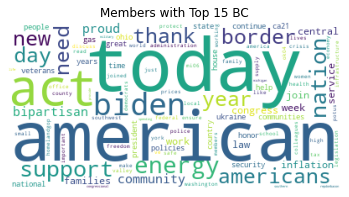

In [60]:
doc15 = []
#Looping over the different members in the democrats list, and opening their tweets-file. 

for member in Top15:
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House", member+".txt"), 'r', encoding="utf-8") as c:
            page2 = c.read()
            doc15.append(page2)
            newlist15 = [re.sub(r'[^a-zA-Z],-+', ' ', x) for x in doc15]
            newlist15 = [re.sub(r'http\S+', '', x) for x in newlist15]
            newlist15 = [re.sub(r'&amp;', '', x) for x in newlist15]
            newlist15 = [re.sub(r'\n', '', x) for x in newlist15]
            

#Creating the TF-IDF scores 
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(newlist15)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)


#Creating the TF-IDF 'vector'
dfnew = df.T.sum(axis=1)
dfnew = dfnew.drop(labels=['rt'])
    
#Plotting the wordcloud
Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(dfnew)
plt.title("Members with Top 15 BC")
plt.imshow(Cloud)
plt.axis("off")
plt.show()

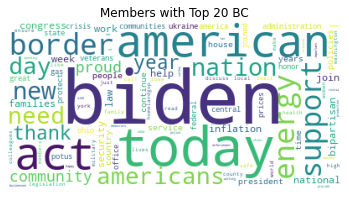

In [75]:
doc19 = []
#Looping over the different members in the democrats list, and opening their tweets-file. 

for member in Top19:
    with open(os.path.join(r"/Users/kathrinesofierasmussen/Library/CloudStorage/GoogleDrive-rasmussen.kathrine20@gmail.com/Mit drev/DTU/M.Sc./1. Semester/02805 Social Graphs and interactions/Final Assignment/House", member+".txt"), 'r', encoding="utf-8") as c:
            page2 = c.read()
            doc19.append(page2)
            newlist19 = [re.sub(r'[^a-zA-Z],-+', ' ', x) for x in doc19]
            newlist19 = [re.sub(r'http\S+', '', x) for x in newlist19]
            newlist19 = [re.sub(r'&amp;', '', x) for x in newlist19]
            newlist19 = [re.sub(r'\n', '', x) for x in newlist19]
            

#Creating the TF-IDF scores 
vectorizer = TfidfVectorizer(stop_words='english')
vecs = vectorizer.fit_transform(newlist19)
feature_names = vectorizer.get_feature_names_out()
dense = vecs.todense()
lst1 = dense.tolist()
df = pd.DataFrame(lst1, columns=feature_names)


#Creating the TF-IDF 'vector'
dfnew = df.T.sum(axis=1)
dfnew = dfnew.drop(labels=['rt'])
    
#Plotting the wordcloud
Cloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(dfnew)
plt.title("Members with Top 20 BC")
plt.imshow(Cloud)
plt.axis("off")
plt.show()

Creating the Bigrams for all 'Top' lists

In [65]:
#Creating the bigram collocations code found on: https://www.nltk.org/howto/collocations.html 
text5 = " ".join(newlist5)

bigram_measures = nltk.collocations.BigramAssocMeasures()

tokens = nltk.wordpunct_tokenize(text5) #Divides the string into lists, where each word is it own 'element'
finder = BigramCollocationFinder.from_words(tokens)
ignored_words = nltk.corpus.stopwords.words('english')#Defining english stopwords
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words) #Removing english stopwords
scored_5 = finder.score_ngrams(bigram_measures.raw_freq)
scored_5

[(('New', 'York'), 0.0006473277501314885),
 (('Bucks', 'County'), 0.0005664117813650524),
 (('Central', 'New'), 0.0005664117813650524),
 (('law', 'enforcement'), 0.0004349233321195938),
 (('United', 'States'), 0.0004146943399279848),
 (('supply', 'chain'), 0.00037423635554476676),
 (('national', 'security'), 0.00035400736335315777),
 (('Hometown', 'Hero'), 0.0003236638750657442),
 (('every', 'day'), 0.0003236638750657442),
 (('Bipartisan', 'Infrastructure'), 0.00031354937896993973),
 (('southern', 'border'), 0.0002933203867783307),
 (('mental', 'health'), 0.0002832058906825262),
 (('Hometown', 'Heroes'), 0.0002528624023951127),
 (('Infrastructure', 'Bill'), 0.00024274790629930817),
 (('bipartisan', 'bill'), 0.00024274790629930817),
 (('look', 'forward'), 0.00023263341020350367),
 (('years', 'ago'), 0.00023263341020350367),
 (('energy', 'production'), 0.00022251891410769915),
 (('first', 'responders'), 0.00022251891410769915),
 (('President', 'Biden'), 0.00020228992191609013),
 (('infra

In [66]:
#Creating the bigram collocations code found on: https://www.nltk.org/howto/collocations.html 
text10 = " ".join(newlist10)

bigram_measures = nltk.collocations.BigramAssocMeasures()

tokens = nltk.wordpunct_tokenize(text10) #Divides the string into lists, where each word is it own 'element'
finder = BigramCollocationFinder.from_words(tokens)
ignored_words = nltk.corpus.stopwords.words('english')#Defining english stopwords
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)#Removing english stopwords
scored_10 = finder.score_ngrams(bigram_measures.raw_freq)
scored_10

[(('law', 'enforcement'), 0.0004758572428271519),
 (('national', 'security'), 0.00046186144156752976),
 (('Central', 'Valley'), 0.00043853510613482623),
 (('Biden', 'administration'), 0.0004245393048752041),
 (('United', 'States'), 0.0004245393048752041),
 (('supply', 'chain'), 0.00038721716818287846),
 (('every', 'day'), 0.0003172381618847679),
 (('New', 'York'), 0.0003032423606251458),
 (('small', 'businesses'), 0.0002892465593655237),
 (('gas', 'prices'), 0.000284581292278983),
 (('energy', 'production'), 0.00026592022393282015),
 (('mental', 'health'), 0.00026592022393282015),
 (('Bucks', 'County'), 0.00026125495684627944),
 (('Central', 'New'), 0.00026125495684627944),
 (('bipartisan', 'bill'), 0.00025658968975973874),
 (('American', 'energy'), 0.0002472591555866573),
 (('energy', 'independence'), 0.0002472591555866573),
 (('small', 'business'), 0.0002472591555866573),
 (('President', 'Biden'), 0.00022393282015395382),
 (('first', 'responders'), 0.00022393282015395382),
 (('southe

In [67]:
#Creating the bigram collocations code found on: https://www.nltk.org/howto/collocations.html 
text15 = " ".join(newlist15)

bigram_measures = nltk.collocations.BigramAssocMeasures()

tokens = nltk.wordpunct_tokenize(text15) #Divides the string into lists, where each word is it own 'element'
finder = BigramCollocationFinder.from_words(tokens)
ignored_words = nltk.corpus.stopwords.words('english')#Defining english stopwords
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)#removing english stopwords
scored_15 = finder.score_ngrams(bigram_measures.raw_freq)
scored_15

[(('law', 'enforcement'), 0.0005474665830088517),
 (('Central', 'Washington'), 0.0005413152730874039),
 (('national', 'security'), 0.000485953483794374),
 (('President', 'Biden'), 0.0004459699693049635),
 (('supply', 'chain'), 0.0004275160395406202),
 (('New', 'York'), 0.0004029107998548291),
 (('United', 'States'), 0.00038445687009048575),
 (('Biden', 'Administration'), 0.00036907859528686636),
 (('Biden', 'administration'), 0.0003290950807974558),
 (('gas', 'prices'), 0.00031986811591528416),
 (('every', 'day'), 0.0003106411510331125),
 (('southern', 'border'), 0.0003106411510331125),
 (('energy', 'production'), 0.00030141418615094086),
 (('American', 'energy'), 0.00029218722126876916),
 (('Central', 'Valley'), 0.0002891115663080453),
 (('small', 'businesses'), 0.0002891115663080453),
 (('energy', 'independence'), 0.00024912805181863477),
 (('look', 'forward'), 0.00020914453732922425),
 (('mental', 'health'), 0.00020914453732922425),
 (('first', 'responders'), 0.00020606888236850037)

In [68]:
#Creating the bigram collocations code found on: https://www.nltk.org/howto/collocations.html 
text19 = " ".join(newlist19)

bigram_measures = nltk.collocations.BigramAssocMeasures()

tokens = nltk.wordpunct_tokenize(text19) #Divides the string into lists, where each word is it own 'element'
finder = BigramCollocationFinder.from_words(tokens)
ignored_words = nltk.corpus.stopwords.words('english')#Defining english stopwords
finder.apply_word_filter(lambda w: len(w) < 3 or w.lower() in ignored_words)#Removing english stopwords. 
scored_20 = finder.score_ngrams(bigram_measures.raw_freq)
scored_20

[(('law', 'enforcement'), 0.0005986140324519231),
 (('national', 'security'), 0.0005774864783653846),
 (('President', 'Biden'), 0.0005399263822115385),
 (('United', 'States'), 0.00044602614182692306),
 (('Central', 'Washington'), 0.0004131610576923077),
 (('Biden', 'Administration'), 0.0003826434795673077),
 (('supply', 'chain'), 0.00037560096153846156),
 (('New', 'York'), 0.00035682091346153844),
 (('energy', 'production'), 0.00034743088942307694),
 (('southern', 'border'), 0.0003333458533653846),
 (('gas', 'prices'), 0.00032630333533653844),
 (('American', 'energy'), 0.0003192608173076923),
 (('Biden', 'administration'), 0.00031691331129807694),
 (('small', 'businesses'), 0.00030987079326923075),
 (('every', 'day'), 0.00029343825120192306),
 (('energy', 'independence'), 0.0002770057091346154),
 (('domestic', 'energy'), 0.00025118314302884613),
 (('American', 'people'), 0.000244140625),
 (('look', 'forward'), 0.00023240309495192306),
 (('Central', 'Valley'), 0.00022066556490384616),
 